In [75]:
import pandas as pd
import json
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA

In [2]:
with open('grandmasterData.json') as f:
  gdData = f.read()
gdDict = json.loads(gdData)

In [3]:
placements = []
traits = []
augments = []
units = []

for summonerID in gdDict.keys():
  for i in range(len(gdDict[summonerID])):
    for puuid, dataDict in gdDict[summonerID][i].items():
      placements.append(dataDict["placement"])
      traits.append(dataDict["traits"])
      augments.append(dataDict["augments"])
      units.append(dataDict["units"])
    # break
  # break
df = pd.DataFrame()
df["placement"] = placements
df["traits"] = traits
df["augments"] = augments
df["units"] = units

df.head()

,placement,traits,augments,units
0,4,"[Set10_Brawler, Set10_Classical, Set10_Country...","[TFT9_Augment_DravenSpoilsOfWar, TFT9_Augment_...","[TFT10_Bard, TFT10_Aphelios, TFT10_MissFortune..."
1,8,"[Set10_Brawler, Set10_Breakout, Set10_Dazzler,...","[TFT7_Augment_AFK, TFT10_Augment_Determinedinv...","[TFT10_KSante, TFT10_Senna, TFT10_Lulu, TFT10_..."
2,3,"[Set10_8Bit, Set10_Brawler, Set10_CrowdDive, S...","[TFT9_Augment_OneTwosThree, TFT9_Augment_Great...","[TFT10_MissFortune, TFT10_Sett, TFT10_Zac, TFT..."
3,6,"[Set10_CrowdDive, Set10_Edgelord, Set10_Execut...","[TFT9_Augment_CustomerIsAlwaysRight, TFT9_Augm...","[TFT10_Lillia, TFT10_Gnar, TFT10_Kayle, TFT10_..."
4,7,"[Set10_Deadeye, Set10_Guardian, Set10_Hyperpop...","[TFT9_Augment_SilverSpoon, TFT9_Augment_Pandor...","[TFT10_Lillia, TFT10_Kennen, TFT10_Seraphine, ..."


In [4]:
mlb = MultiLabelBinarizer()
df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('traits')),
                                            columns=mlb.classes_,
                                            index=df.index).add_prefix("trait_"))

df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('units')),
                                            columns=mlb.classes_,
                                            index=df.index).add_prefix("unit_"))

df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('augments')),
                                            columns=mlb.classes_,
                                            index=df.index).add_prefix("augment_"))
df.head()

,placement,trait_Astro,trait_Battlecast,trait_Blaster,trait_Chrono,trait_Cybernetic,trait_DarkStar,trait_Demolitionist,trait_Infiltrator,trait_ManaReaver,...,augment_TFT9_Augment_TiniestTitan,augment_TFT9_Augment_TiniestTitanPlus,augment_TFT9_Augment_TonsOfStats,augment_TFT9_Augment_TwoHealthy,augment_TFT9_Augment_UnleashedArcana,augment_TFT9_Augment_WhatDoesntKillYou,augment_TFT9_Augment_WhatTheForge,augment_TFT9_Augment_YouHaveMyBow,augment_TFT9_Augment_YouHaveMySword,augment_TFT9_Augment_YoungAndWildAndFree
0,4,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
def reduceFeatures(df, target, n_components):
    features = list(df.columns)
    features.remove(target)

    pca = PCA(n_components=n_components)
    components = pca.fit_transform(df[features])

    PCs = []
    colNames = []
    for i in range(n_components):
        PCs.append(components[:,i])
        colNames.append(f"PC{i+1}")

    zipped = list(zip(*PCs,
                      df[target]))

    pc_df = pd.DataFrame(zipped,
                         columns=[*colNames,
                                      target])

    return pc_df

In [81]:
# n_components necessary to explain 80% of the variance
pc_df = reduceFeatures(df, "placement", 60)
pc_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,placement
0,2.472877,-0.516134,-0.423691,1.090205,1.647069,0.461293,0.476847,0.901300,0.322716,-0.074293,...,-0.124162,-0.094763,0.047236,0.015182,-0.049969,-0.062884,-0.010382,0.072809,0.181199,4
1,-0.617901,-1.594665,0.718297,0.053679,-0.698366,-0.376898,0.376407,-0.765911,1.074960,0.675118,...,0.304155,0.233371,-0.154335,0.011168,0.087671,-0.029743,-0.091096,-0.290039,-0.059844,8
2,2.198565,-0.209806,-0.137471,-1.152329,-0.889903,0.451189,-0.199988,-0.263537,-0.187490,0.905170,...,-0.119245,0.024910,0.068776,0.175230,-0.047971,0.043557,-0.054679,-0.100276,0.075136,3
3,-1.219602,2.168358,-0.343407,-0.250048,0.082409,-1.092121,-0.005954,0.251830,0.044844,-0.370541,...,-0.043863,-0.303598,0.272725,0.254408,-0.107825,0.085744,0.023690,0.000118,0.004790,6
4,-2.155069,-1.364458,0.006957,-0.529022,0.315305,0.163537,-1.048462,0.569003,-0.675836,-0.149915,...,-0.044975,0.090584,-0.165070,-0.027207,0.410916,0.308482,-0.263234,0.127221,-0.157392,7


In [84]:
top4DF = pc_df.copy()
for i, row in top4DF.iterrows():
    if row["placement"] > 4:
        top4DF.at[i,"placement"] = 1
    else:
        top4DF.at[i,"placement"] = 0
top4DF.head()

X_train, X_test, y_train, y_test = train_test_split(top4DF.drop('placement', axis=1), top4DF["placement"], test_size=0.25)
X_train.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60
10406,2.557881,0.115551,-0.339651,-0.365984,0.922692,-0.496201,0.725215,0.424824,0.065489,-0.395598,...,-0.209091,-0.062423,0.240208,-0.179747,-0.356516,0.191684,0.186447,-0.100027,0.043850,0.062084
40413,2.014211,0.123388,-0.542827,0.788370,0.726734,-0.460786,-0.418174,1.278036,0.858866,-0.194559,...,-0.266815,-0.297394,0.071809,-0.200035,-0.245925,0.559731,0.488542,0.030040,-0.057204,0.137546
1504,2.403511,-0.588198,-0.530563,-0.237049,-0.075749,-0.813787,-0.385940,-0.758086,-0.437153,-0.053458,...,-0.083577,-0.176643,-0.291494,0.002824,-0.215214,0.002160,-0.009827,-0.111372,0.124030,0.086299
31705,0.530054,1.712140,2.327931,-0.531884,0.285542,0.969255,-0.680791,0.010973,-0.091377,-0.161389,...,0.070442,0.064698,-0.030055,0.063135,-0.111398,-0.077911,0.020177,0.127493,-0.403143,0.016379
24104,2.605744,0.137402,-0.057314,-1.084159,-0.725804,-0.319441,-0.898770,-0.303576,0.058984,0.154688,...,0.300141,-0.087565,-0.038988,0.015708,-0.020747,0.208610,-0.016009,-0.014321,-0.162176,0.179161


In [85]:
def plotClusters(X_labels, X_data, clusters, PCs):

    full_df = X_data.copy()
    full_df.insert(0, "Cluster_Labels", X_labels)
    full_df = full_df.loc[:,:f"PC{PCs}"]

    cPal = sns.color_palette("bright", n_colors=clusters)

    g = sns.PairGrid(data=full_df,
                    hue="Cluster_Labels")
    g.map(sns.scatterplot, linewidth=0, s=1, palette=cPal)

    plt.suptitle(f"TFT PCA KMeans Clustering with {clusters} Clusters",
              fontsize=16)
    g.fig.subplots_adjust(top=0.9)
    g.add_legend()

    plt.show()

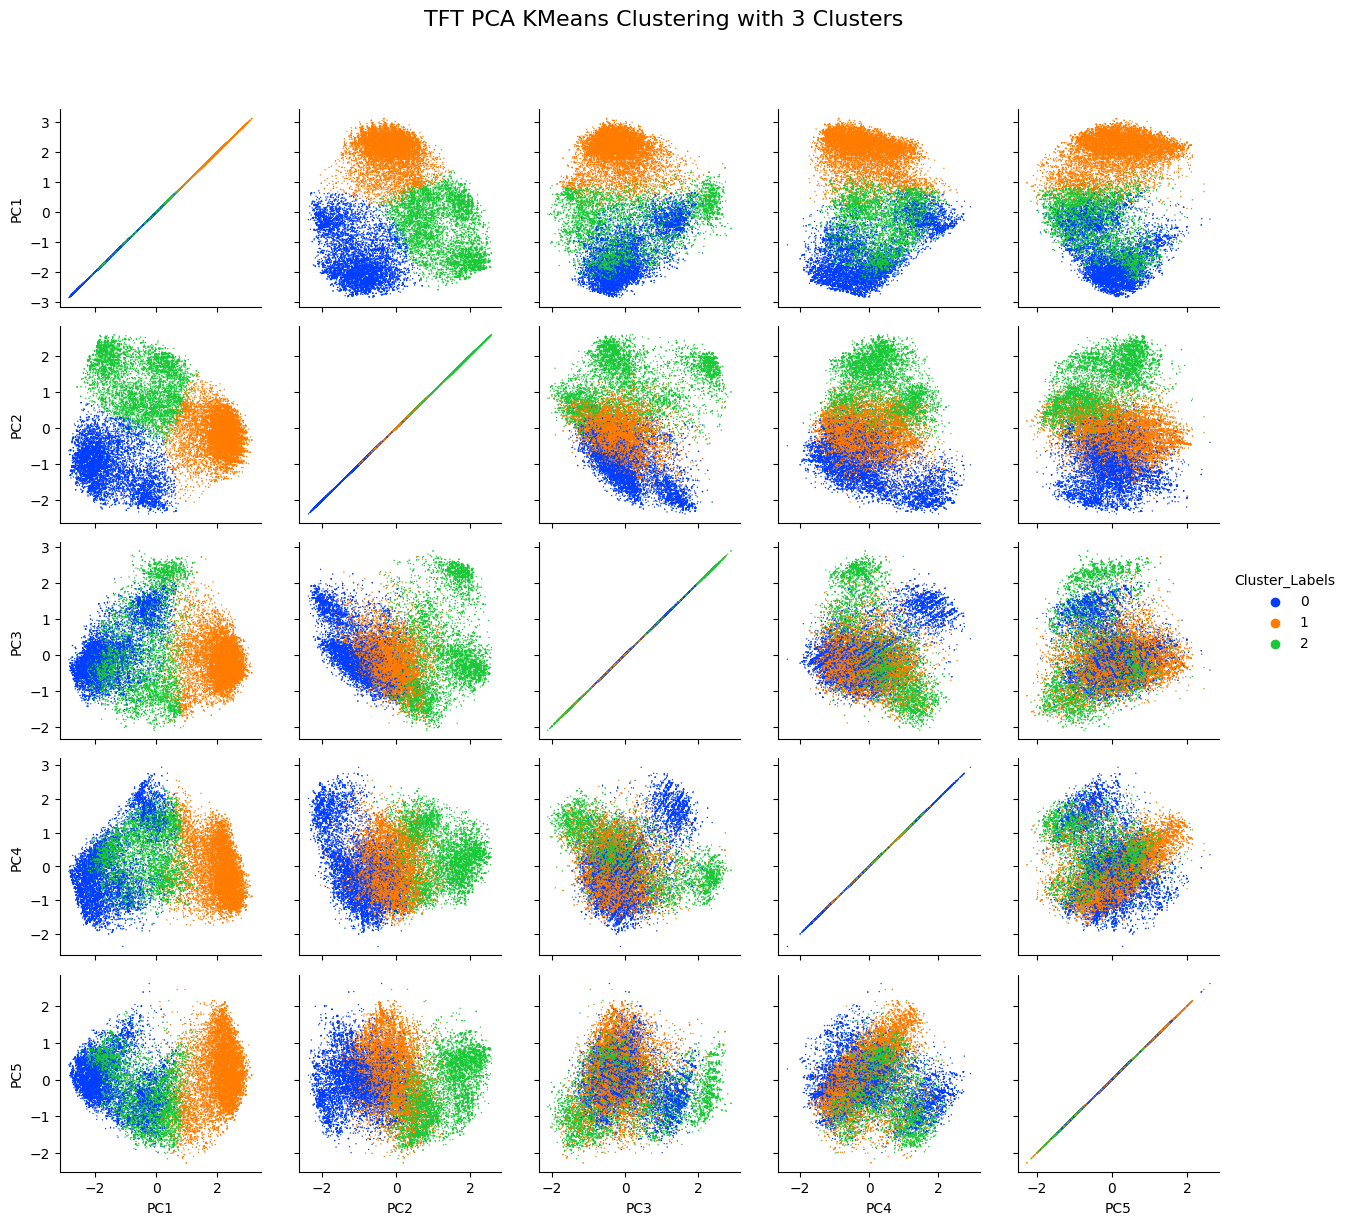

In [86]:
clusters = 3
PCs = 5
kmeansClustering = KMeans(n_clusters=clusters, max_iter=1000, algorithm="elkan").fit(X_train)
plotClusters(kmeansClustering.labels_, X_train, clusters, PCs)